In [26]:
# !pip install datasets transformers
# !pip install transformers[torch]
!pip install accelerate>=0.26.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset
import torch
from sklearn.preprocessing import OneHotEncoder

import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
print("Weights & Biases отключён")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Используем устройство:', device)

Weights & Biases отключён
Используем устройство: cuda


In [4]:
device = 'cpu'

In [3]:
# https://huggingface.co/datasets/blinoff/kinopoisk
# 36 000 rows
dataset = load_dataset("blinoff/kinopoisk", split="train")

In [4]:
dataset

Dataset({
    features: ['part', 'movie_name', 'review_id', 'author', 'date', 'title', 'grade3', 'grade10', 'content'],
    num_rows: 36591
})

In [5]:
content, result = dataset['content'], dataset['grade3']
df = pd.DataFrame({'content': content, 'result': result})
df.head()

,content,result
0,"\n""Блеф» — одна из моих самых любимых комедий....",Good
1,\nАдриано Челентано продолжает радовать нас св...,Good
2,"\nНесомненно, это один из великих фильмов 80-х...",Good
3,\nЭта фраза на мой взгляд отражает сюжет несом...,Good
4,"\n- как пела Земфира, скорее всего, по соверше...",Neutral


In [6]:
def convert_result(row):
  mark = 0
  if row['result'] == 'Good':
    mark = 4
  elif row['result'] == 'Neutral':
    mark = 2

  row['target'] = mark
  return row

In [12]:
df[5:15].apply(convert_result, axis=1)

,content,result,target
5,"\nБесспорный классический шедевр, который и че...",Good,4
6,"\n- Ну, так что ты скажешь по поводу нашей сов...",Good,4
7,\nФинансовая акула Белль Дюк имеет давние счёт...,Neutral,2
8,\nВесьма забавное и легкое кино. Челентано как...,Good,4
9,"\nНаверное, всё-таки самый лучший фильм с учас...",Good,4
10,\n«Блеф» — комедия Серджио Корбуччи 1976 года....,Good,4
11,\nДействие фильма разворачивается примерно в 1...,Good,4
12,"\nКак и почти каждый киношедевр, картина «Блеф...",Good,4
13,\n«Мы должны поставить всё против всего!»\n\nИ...,Good,4
14,"\nВсе могут короли! И короли не только блефа, ...",Good,4


In [7]:
df = df.apply(convert_result, axis=1)
df.target.value_counts()

target
4    27264
0     4751
2     4576
Name: count, dtype: int64

In [33]:
test1, train1 = df[df.target == 4][:1000], df[df.target == 4][1000:3000]
test2, train2 = df[df.target == 0][:1000], df[df.target == 0][1000:3000]
test3, train3 = df[df.target == 2][:1000], df[df.target == 2][1000:3000]
test = pd.concat([test1, test2, test3])
test.target.value_counts()

,count
target,
4,1000
0,1000
2,1000


In [34]:
train = pd.concat([train1, train2, train3])
train.target.value_counts()

,count
target,
4,2000
0,2000
2,2000


In [16]:
test.head()

,content,result,target
0,"\n""Блеф» — одна из моих самых любимых комедий....",Good,4
1,\nАдриано Челентано продолжает радовать нас св...,Good,4
2,"\nНесомненно, это один из великих фильмов 80-х...",Good,4
3,\nЭта фраза на мой взгляд отражает сюжет несом...,Good,4
5,"\nБесспорный классический шедевр, который и че...",Good,4


# BERT

In [17]:
model_checkpoint = 'tabularisai/multilingual-sentiment-analysis'

In [18]:
# Инициализация предобученного pipeline для анализа тональности
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_checkpoint,
    device=0 if device=='cuda' else -1
    # device = -1
)

# Применяем pipeline к текстам датасета. Приводим данные к списку и задаём обрезку длинных последовательностей
predictions = sentiment_pipeline(test.content[:10].to_list(), truncation=True, max_length=512)
predictions

Device set to use cuda:0


[{'label': 'Positive', 'score': 0.2990826368331909},
 {'label': 'Neutral', 'score': 0.3124943971633911},
 {'label': 'Very Positive', 'score': 0.8216116428375244},
 {'label': 'Very Negative', 'score': 0.4335016906261444},
 {'label': 'Very Negative', 'score': 0.3876231908798218},
 {'label': 'Very Negative', 'score': 0.6889387965202332},
 {'label': 'Positive', 'score': 0.5385136604309082},
 {'label': 'Very Negative', 'score': 0.5246408581733704},
 {'label': 'Positive', 'score': 0.5181668996810913},
 {'label': 'Neutral', 'score': 0.46285581588745117}]

In [104]:
def convert(ds):
  pred_labels = []
  for i in ds:
    tmp = 2
    # if 'Good' in i or i=='Positive' or i == 'Very Positive':
    #   tmp = 4
    # elif 'Negative' in i or i=='Bad':
    #   tmp = 0

    if 'Positive' in i['label']:
      tmp = 4
    elif 'Negative' in i['label']:
      tmp = 0

    pred_labels.append(tmp)

  return pred_labels

In [105]:
predictions = sentiment_pipeline(test.content.to_list(), truncation=True, max_length=512)
pred_labels = convert(predictions)

# Истинные метки из датасета
true_labels = test.target.to_list()

# Вычисляем точность и выводим классификационный отчёт
acc = accuracy_score(true_labels, pred_labels)
print("Accuracy of out-of-the-box model:", acc)
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, labels=[4, 2, 0], target_names=[ "Positive", 'Neutral', "Negative"], zero_division=0))

Accuracy of out-of-the-box model: 0.49333333333333335

Classification Report:
              precision    recall  f1-score   support

    Positive       0.64      0.48      0.55      1000
     Neutral       0.40      0.43      0.42      1000
    Negative       0.49      0.57      0.53      1000

    accuracy                           0.49      3000
   macro avg       0.51      0.49      0.50      3000
weighted avg       0.51      0.49      0.50      3000



In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [22]:
inputs = tokenizer(test['content'][10][:100], truncation=True, padding="max_length", max_length=256)
print(inputs.keys(), inputs.input_ids)

dict_keys(['input_ids', 'attention_mask']) [101, 208, 510, 11851, 13582, 220, 100, 65812, 20742, 52203, 23479, 74999, 519, 13097, 19590, 11746, 14208, 10705, 10334, 119, 37742, 10387, 552, 10593, 13647, 41194, 58356, 99052, 543, 28155, 15990, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
enc = OneHotEncoder()
enc.fit([[i] for i in range(5)])
enc.categories_, list(enc.transform([[0],[0], [1]]).toarray())

([array([0, 1, 2, 3, 4])],
 [array([1., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0.]),
  array([0., 1., 0., 0., 0.])])

In [24]:
text = []
label = []
attention_mask = []
input_ids = []

def to_target_ds(row):
  tmp = tokenizer(row['content'], truncation=True, padding="max_length", max_length=256)

  input_ids.append(torch.tensor(tmp['input_ids']))
  attention_mask.append(torch.tensor(tmp['attention_mask']))
  label.append(torch.tensor(row['target']))

  text.append(row['content'])
  return row

In [25]:
np.array(2).reshape(-1, 1), torch.IntTensor([[0,0, 1, 0, 0]][0]), torch.LongTensor([2]), torch.tensor(2), torch.tensor([1, 2, 3])

(array([[2]]),
 tensor([0, 0, 1, 0, 0], dtype=torch.int32),
 tensor([2]),
 tensor(2),
 tensor([1, 2, 3]))

In [26]:
def to_hg_ds(df):
  df = df.apply(to_target_ds, axis = 1)

  table = Dataset.from_dict({'input_ids': input_ids,
                             'attention_mask': attention_mask,
                             'label': label,
                             'text': text})
  return table

In [27]:
Dataset.from_dict({'a': torch.IntTensor([1, 2, 3])})

Dataset({
    features: ['a'],
    num_rows: 3
})

In [37]:
train_ds = to_hg_ds(train)
text = []
label = []
attention_mask = []
input_ids = []
test_ds = to_hg_ds(test)

In [38]:
train_ds, test_ds

(Dataset({
     features: ['input_ids', 'attention_mask', 'label', 'text'],
     num_rows: 12000
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'label', 'text'],
     num_rows: 3000
 }))

In [ ]:
# type(train_ds['label'][0]), train_ds[0]

In [41]:
# Определяем аргументы для обучения (без evaluation_strategy и load_best_model_at_end)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,  # для демонстрации используем 2 эпохи
    per_device_train_batch_size=100,
    per_device_eval_batch_size=100,
    logging_dir="./logs",
    logging_steps=10,
    metric_for_best_model="accuracy"
)

# Функция для вычисления метрик (точности)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}


# Инициализируем Trainer c той же моделью, что и для оценки
trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5, ignore_mismatched_sizes=True),
    args=training_args,
    train_dataset= train_ds,
    eval_dataset= test_ds,
    compute_metrics=compute_metrics
)

# Запускаем дообучение
trainer.train()

# Оцениваем качество модели на валидационном наборе
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,1.397800
20,0.974700
30,0.897200
40,0.773900
50,0.795200
60,0.766200
70,0.771000
80,0.741500
90,0.684700
100,0.695800


Evaluation results: {'eval_loss': 0.5604040622711182, 'eval_accuracy': 0.7706666666666667, 'eval_runtime': 19.8642, 'eval_samples_per_second': 151.025, 'eval_steps_per_second': 1.51, 'epoch': 2.0}


In [38]:
def confusion_matrix_info(pipe):
  predictions = pipe(test.content.to_list(), truncation=True, max_length=512)
  pred_labels = convert(predictions)

  # Истинные метки из датасета
  true_labels = test.target.to_list()

  # Вычисляем точность и выводим классификационный отчёт
  acc = accuracy_score(true_labels, pred_labels)
  print("Accuracy of out-of-the-box model:", acc)
  print("\nClassification Report:")
  print(classification_report(true_labels, pred_labels, labels=[4, 2, 0], target_names=[ "Positive", 'Neutral', "Negative"], zero_division=0))

  cm_ft = confusion_matrix(true_labels, pred_labels)
  plt.figure(figsize=(6,4))
  sns.heatmap(cm_ft, annot=True, fmt="d", cmap="Greens", xticklabels=["Positive", 'Neutral', "Negative"], yticklabels=["Positive", 'Neutral', "Negative"])
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix for Fine-tuned Model")
  plt.show()

In [59]:
# Используем дообученную модель через pipeline для предсказаний
sentiment_pipeline_ft = pipeline(
      "sentiment-analysis",
      model=trainer.model,
      tokenizer=tokenizer,
      device=0 if device=='cuda' else -1
)

Device set to use cuda:0


Accuracy of out-of-the-box model: 0.7303333333333333

Classification Report:
              precision    recall  f1-score   support

    Positive       0.67      0.97      0.79      1000
     Neutral       0.81      0.37      0.51      1000
    Negative       0.78      0.85      0.82      1000

    accuracy                           0.73      3000
   macro avg       0.75      0.73      0.70      3000
weighted avg       0.75      0.73      0.70      3000



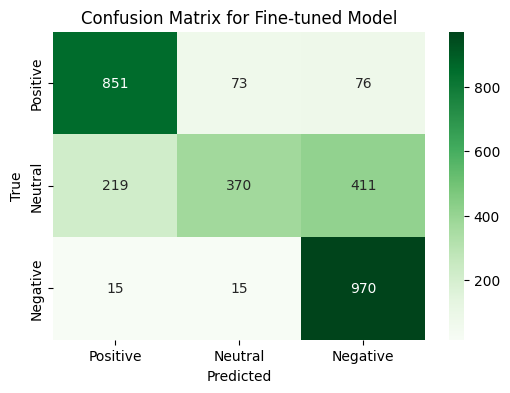

In [114]:
confusion_matrix_info(sentiment_pipeline_ft)

In [117]:
trainer.save_model("sent_fun.pt")

In [118]:
trainer.save_model("sent_fun_1")

In [126]:
tokenizer.save_pretrained("./tokenizer/")

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json',
 './tokenizer/tokenizer.json')

In [128]:
tokenizer1 = AutoTokenizer.from_pretrained('./tokenizer')
model1 = AutoModelForSequenceClassification.from_pretrained("sent_fun_1")
sent1 = pipeline(
    "sentiment-analysis",
    model=model1,
    tokenizer=tokenizer1,
    # device=0 if device=='cuda' else -1
    device = -1
)

Device set to use cpu


In [131]:
sent1('Этот солнечный день...')

[{'label': 'Very Positive', 'score': 0.7685285806655884}]

# Train with changing hyperparameters

In [8]:
test1, train1 = df[df.target == 4][:128], df[df.target == 4][1000:1256]
test2, train2 = df[df.target == 0][:128], df[df.target == 0][1000:1256]
test3, train3 = df[df.target == 2][:128], df[df.target == 2][1000:1256]
test = pd.concat([test1, test2, test3])
test.target.value_counts()

target
4    128
0    128
2    128
Name: count, dtype: int64

In [9]:
train = pd.concat([train1, train2, train3])
train.target.value_counts()

target
4    256
0    256
2    256
Name: count, dtype: int64

In [10]:
model_checkpoint = 'tabularisai/multilingual-sentiment-analysis'

In [11]:
# Инициализация предобученного pipeline для анализа тональности
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model_checkpoint,
    device=0 if device=='cuda' else -1
    # device = -1
)

# Применяем pipeline к текстам датасета. Приводим данные к списку и задаём обрезку длинных последовательностей
predictions = sentiment_pipeline(test.content[:10].to_list(), truncation=True, max_length=512)
predictions

Device set to use cuda:0


[{'label': 'Positive', 'score': 0.2990821897983551},
 {'label': 'Neutral', 'score': 0.3124946653842926},
 {'label': 'Very Positive', 'score': 0.8216116428375244},
 {'label': 'Very Negative', 'score': 0.43350160121917725},
 {'label': 'Very Negative', 'score': 0.38762253522872925},
 {'label': 'Very Negative', 'score': 0.6889384984970093},
 {'label': 'Positive', 'score': 0.5385134816169739},
 {'label': 'Very Negative', 'score': 0.5246408581733704},
 {'label': 'Positive', 'score': 0.5181668400764465},
 {'label': 'Neutral', 'score': 0.4628553092479706}]

In [12]:
def convert(ds):
  pred_labels = []
  for i in ds:
    tmp = 2
    if 'Positive' in i['label']:
      tmp = 4
    elif 'Negative' in i['label']:
      tmp = 0

    pred_labels.append(tmp)

  return pred_labels

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [14]:
text = []
label = []
attention_mask = []
input_ids = []

def to_target_ds(row):
  tmp = tokenizer(row['content'], truncation=True, padding="max_length", max_length=256)

  input_ids.append(torch.tensor(tmp['input_ids']))
  attention_mask.append(torch.tensor(tmp['attention_mask']))
  label.append(torch.tensor(row['target']))

  text.append(row['content'])
  return row

In [15]:
def to_hg_ds(df):
  df = df.apply(to_target_ds, axis = 1)

  table = Dataset.from_dict({'input_ids': input_ids,
                             'attention_mask': attention_mask,
                             'label': label,
                             'text': text})
  return table

In [16]:
train_ds = to_hg_ds(train)
text = []
label = []
attention_mask = []
input_ids = []
test_ds = to_hg_ds(test)

In [17]:
train_ds, test_ds

(Dataset({
     features: ['input_ids', 'attention_mask', 'label', 'text'],
     num_rows: 768
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'label', 'text'],
     num_rows: 384
 }))

In [31]:
acc_list = []

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10, 
    per_device_train_batch_size=30,
    per_device_eval_batch_size=30,
    logging_dir="./logs",
    logging_steps=10,
    metric_for_best_model="accuracy",
    eval_strategy = "epoch",
    logging_strategy="epoch"
)

def compute_metrics(eval_pred):
    global acc_list
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    acc_list.append(acc)
    return {"accuracy": acc}


trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5, ignore_mismatched_sizes=True),
    args=training_args,
    train_dataset= train_ds,
    eval_dataset= test_ds,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy
1,0.945000,1.498252,0.388021
2,0.541400,1.538571,0.479167
3,0.240700,2.044008,0.476562
4,0.115900,2.640370,0.455729
5,0.053100,2.972289,0.455729
6,0.016400,3.291608,0.466146
7,0.004000,3.849947,0.403646
8,0.009000,3.710782,0.429688
9,0.001400,3.765852,0.432292
10,0.001300,3.793133,0.432292


Evaluation results: {'eval_loss': 3.793133497238159, 'eval_accuracy': 0.4322916666666667, 'eval_runtime': 4.4315, 'eval_samples_per_second': 86.653, 'eval_steps_per_second': 2.934, 'epoch': 10.0}


In [32]:
trainer.state.log_history

[{'loss': 0.945,
  'grad_norm': 10.186881065368652,
  'learning_rate': 4.5e-05,
  'epoch': 1.0,
  'step': 26},
 {'eval_loss': 1.4982523918151855,
  'eval_accuracy': 0.3880208333333333,
  'eval_runtime': 4.4036,
  'eval_samples_per_second': 87.201,
  'eval_steps_per_second': 2.952,
  'epoch': 1.0,
  'step': 26},
 {'loss': 0.5414,
  'grad_norm': 8.13337230682373,
  'learning_rate': 4e-05,
  'epoch': 2.0,
  'step': 52},
 {'eval_loss': 1.538570523262024,
  'eval_accuracy': 0.4791666666666667,
  'eval_runtime': 4.4352,
  'eval_samples_per_second': 86.579,
  'eval_steps_per_second': 2.931,
  'epoch': 2.0,
  'step': 52},
 {'loss': 0.2407,
  'grad_norm': 19.810073852539062,
  'learning_rate': 3.5e-05,
  'epoch': 3.0,
  'step': 78},
 {'eval_loss': 2.044008255004883,
  'eval_accuracy': 0.4765625,
  'eval_runtime': 4.4187,
  'eval_samples_per_second': 86.903,
  'eval_steps_per_second': 2.942,
  'epoch': 3.0,
  'step': 78},
 {'loss': 0.1159,
  'grad_norm': 22.663524627685547,
  'learning_rate': 3e

In [34]:
acc = []
loss = []

for i in trainer.state.log_history:
    if 'eval_loss' in i:
        acc.append(i['eval_accuracy'])
        loss.append(i['eval_loss'])

Text(0.5, 1.0, 'Accuracy and loss')

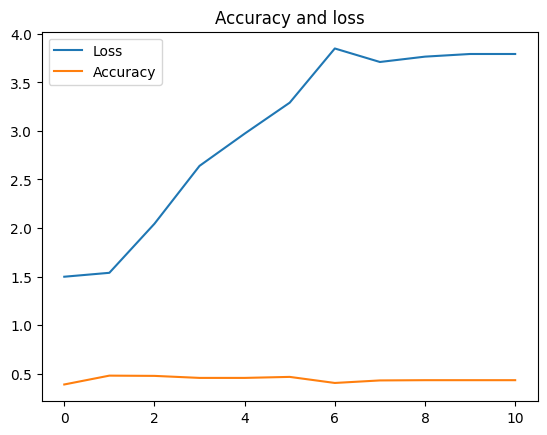

In [35]:
plt.plot(loss, label = 'Loss')
plt.plot(acc, label = 'Accuracy')
plt.legend()
plt.title('Accuracy and loss')

In [36]:
sentiment_pipeline_ft = pipeline(
      "sentiment-analysis",
      model=trainer.model,
      tokenizer=tokenizer,
      device=0 if device=='cuda' else -1
)

Device set to use cuda:0


Accuracy of out-of-the-box model: 0.4505208333333333

Classification Report:
              precision    recall  f1-score   support

    Positive       0.40      0.52      0.45       128
     Neutral       0.34      0.32      0.33       128
    Negative       0.67      0.51      0.58       128

    accuracy                           0.45       384
   macro avg       0.47      0.45      0.45       384
weighted avg       0.47      0.45      0.45       384



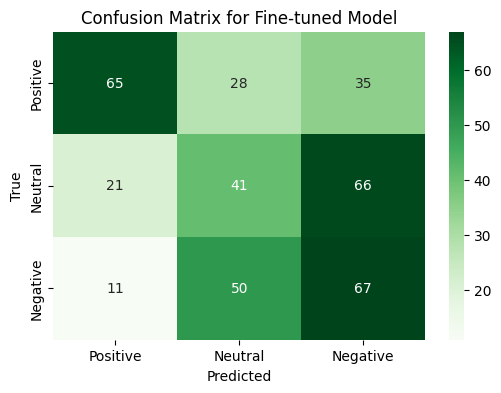

In [39]:
confusion_matrix_info(sentiment_pipeline_ft)